## Install the PGR-TK package

If neccessary, install the package into your python environment 
```
pip install --force /code/pgrtk-0.3.2-cp38-cp38-linux_x86_64.whl
```

In [1]:
import pgrtk
import os
import matplotlib.pyplot as plt
from IPython.display import SVG
%matplotlib inline

In [2]:
pgrtk.__version__

'pgrtk 0.3.4 (main:59af6a0, release build, linux [x86_64] [rustc 1.62.0 (a8314ef7d 2022-06-27)])'

In [3]:
os.chdir("/results")

## Lazy load the the AGCfile for fetching sequences

In [4]:
ref_db =pgrtk.AGCFile("/data/pgr-tk-HGRP-y1-evaluation-set-v0.agc")

## Load the index into memory
The loads the index into the memory. It takes about one minute.

In [5]:
%%time
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("/data/pgr-tk-HGRP-y1-evaluation-set-v0")


CPU times: user 23.4 s, sys: 7min 3s, total: 7min 27s
Wall time: 29.8 s


We can see the specification about how SHIMMERs are computed using the `get_shmmr_spec()` method. 

In [6]:
sdb.get_shmmr_spec() # window_size, k_mer_size, hieraical_reduction_factor, min_span, use_k_mer_sketch_other_than_minimizer

(80, 56, 4, 64, False)

## Query the database with the sequence of the region

We use a copy of the annotation for IGV hg19 to look up the chromosome and locations of the gene of interest.
We can fetch the region of interest with `ref_db`. Let's fetch the whole region and do a dot plot to examine the repeat structure. 

84


(0.0, 144893.0)

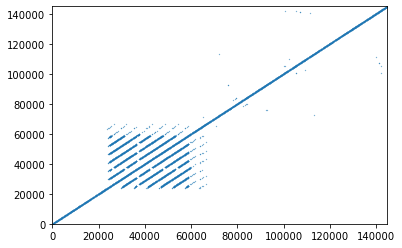

In [7]:
ref_file_name, roi_chr, roi_b, roi_e = 'hg19_tagged.fa', 'chr6_hg19', 160952514, 161087407
padding = 5000
roi_len = roi_e - roi_b
#get a segment of a reference
roi_seq = ref_db.get_sub_seq(ref_file_name, roi_chr, roi_b-padding, roi_e+padding)
roi_seq = pgrtk.rc_byte_seq(roi_seq)
x, y = pgrtk.get_shmmr_dots(roi_seq, roi_seq, 32, 32, 2, 2)
plt.plot(x, y, ".", markersize=0.5)
print(x[0])
plt.xlim(0,len(roi_seq))
plt.ylim(0,len(roi_seq))

In [8]:
#find hits in the pangenomic reference
aln_range = pgrtk.query_sdb(sdb, roi_seq, merge_range_tol=100000)

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 106
The total aligned regions is 106


We can examine, the target region sizes.

In [9]:
rgn_lengths = []
for k in list(aln_range.keys()):
    b, e = aln_range[k][0][0:2]
    print(sdb.seq_info[k], "target region", b, "-", e, "len:", e-b )
    rgn_lengths.append(e-b)

('HG01978#1#JAGYVS010000033.1', 'HG01978.paternal.f1_assembly_v2_genbank.fa', 22149523) target region 10088080 - 10322803 len: 234723
('HG03453#2#JAGYVV010000137.1', 'HG03453.maternal.f1_assembly_v2_genbank.fa', 6415337) target region 4877834 - 5067318 len: 189484
('HG00735#1#JAHBCH010000011.1', 'HG00735.paternal.f1_assembly_v2_genbank.fa', 102288089) target region 100727749 - 100944840 len: 217091
('HG01123#2#JAGYYY010000009.1', 'HG01123.maternal.f1_assembly_v2_genbank.fa', 103078045) target region 10087428 - 10344303 len: 256875
('HG02109#1#JAHEPG010000154.1', 'HG02109.paternal.f1_assembly_v2_genbank.fa', 2902882) target region 2831 - 143136 len: 140305
('HG03486#1#JAHEOQ010000122.1', 'HG03486.paternal.f1_assembly_v2_genbank.fa', 6444572) target region 1352201 - 1547229 len: 195028
('HG01358#2#JAGYZA010000101.1', 'HG01358.maternal.f1_assembly_v2_genbank.fa', 10246933) target region 10094247 - 10245241 len: 150994
('HG02055#2#JAHEPJ010000107.1', 'HG02055.maternal.f1_assembly_v2_genban

Text(0, 0.5, 'count')

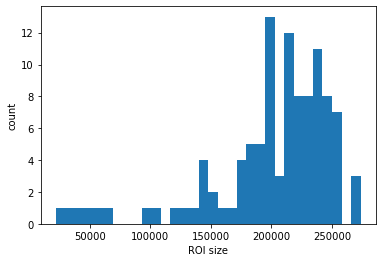

In [10]:
plt.hist(rgn_lengths, bins=32);
plt.xlabel("ROI size")
plt.ylabel("count")

Some mapped regions are larger, let's check the repeat / CNV by quick dot plots. We label the region of the ROI by two vertical grey lines. We observe that there are different number of intersections (~different copy number of the ROI) of the region the "dots" due to the different repeat structures.

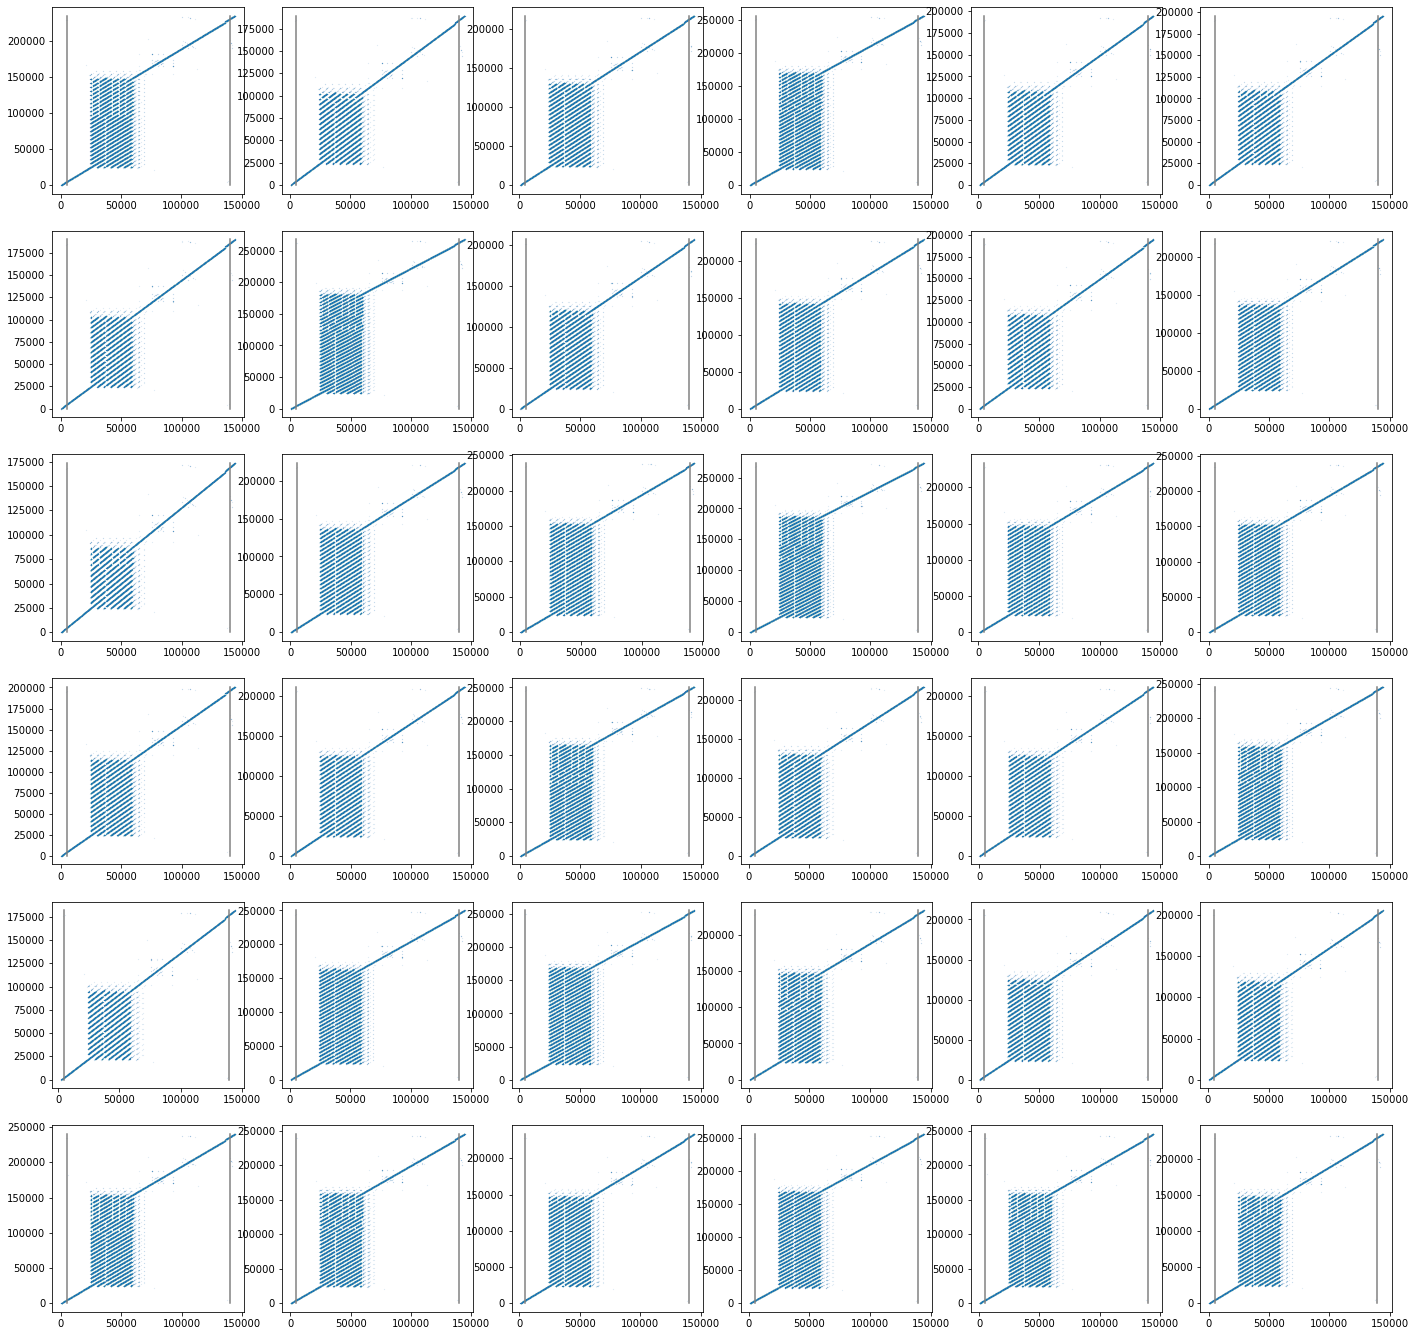

In [11]:
seq_list = []
i = 1
plt.figure(figsize=(24, 24))
for k in list(aln_range.keys()):
    ctg_name, source, _ = sdb.seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()

    rgns = pgrtk.merge_regions(rgns, tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        aln.sort()
      
        if aln[0][0][0] > padding  or aln[-1][0][1] < padding + roi_len:
            continue
      

        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
        

        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)

        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        x, y = pgrtk.get_shmmr_dots(roi_seq, seq, 32, 32, 1, 1)
        
        
        if i <= 36:
            plt.subplot(6,6,i)
            plt.plot(x, y, ".", markersize=0.1)
            plt.plot([padding, padding],[0, max(y)], color='grey')
            plt.plot([padding+roi_len, padding+roi_len],[0, max(y)], color='grey')
        i += 1
        
        
        
        

## Create a new shimmer database for the detailed study

In [12]:
seq_list = []
seq_info = sdb.seq_info.copy()
i = 0
for k in list(aln_range.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()
    
    rgns = pgrtk.merge_regions(rgns,tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region
        if aln[0][0][0] > padding  or aln[-1][0][1] < padding + roi_len:
            continue
        #if e-b < 0.75 * (roi_len + 2 * padding):             
        #    continue
            
        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        i += 1



Create a shimmer indext database with smaller window (denser shimmers)

In [13]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=6, min_span=18)

In [14]:
len(new_sdb.seq_info)

92

In [15]:
#find hits in the pangenomic reference
aln_range0 = pgrtk.query_sdb(new_sdb, roi_seq, merge_range_tol=300000)

aln_range = aln_range0

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 92
The total aligned regions is 92


Let's loop through the hits (contigs that has alignments) and see the number of "copies".

In [16]:
from collections import Counter

In [17]:
n_copy = {}
for k in list(aln_range.keys()):
    n_copy[k] = len(aln_range[k])
copy_count = Counter(n_copy.values())
for nc, nh in copy_count.items():
    print("number of copy: {}, number of haplotypes: {}".format(nc, nh))

number of copy: 1, number of haplotypes: 92


Text(0, 0.5, 'count')

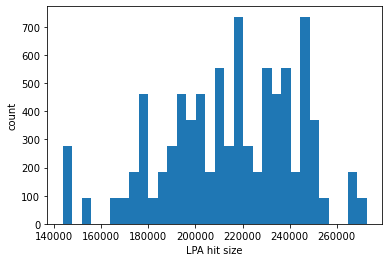

In [18]:
rgn_lengths = []
for k in list(aln_range.keys()):
    for sid, rgns in aln_range.items():
        for rgn in rgns:
            b, e = rgn[0:2]
            #print(seq_index[k], "target region", b, "-", e, "len:", e-b )
            rgn_lengths.append(e-b)
plt.hist(rgn_lengths, bins=32);
plt.xlabel("LPA hit size")
plt.ylabel("count")

In [19]:
f0 = open("/results/ROI_seq.fa", "w")
for ctg, seq in seq_list:
    
    print(">{}".format(ctg), file=f0)
    print(pgrtk.u8_to_string(seq), file=f0)
       
f0.close()

In [20]:
!cp /results/ROI_seq.fa /results/LPA_ROI_seq.fa ## avoid overiding by other notebook

In [21]:
help(new_sdb.generate_mapg_gfa)

Help on built-in function generate_mapg_gfa:

generate_mapg_gfa(...) method of builtins.SeqIndexDB instance
    Convert the adjecent list of the shimmer graph shimmer_pair -> GFA
    
    Parameters
    ----------
    min_count : int
        the minimum number of times a pair of shimmers must be observed to be included in the graph
    
    filenpath : string
        the path to the output file
    
    Returns
    -------
    
    None
        The data is written into the file at filepath



In [22]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=6, min_span=28)
new_sdb.generate_mapg_gfa(0, "/results/LPA_ROI_80_56_6_28.gfa")

new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=2, min_span=28)
new_sdb.generate_mapg_gfa(0, "/results/LPA_ROI_80_56_2_28.gfa")

## Construct the genome graphs

In [23]:
import networkx as nx
from networkx.drawing import nx_pydot 

In [24]:
def get_graph(seq_list, w=128, k=56, r=4, min_span=28, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=min_span)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  2 + 0.1 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    node_to_sid = {}
    for v in G.nodes():
        node_to_sid.setdefault(v, {})
        for sid, path in sid_to_path.items():
            node_to_sid[v][sid] = 0
            
     
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        for v in path:
            v = tuple(v[-2:])
            node_to_sid[v][sid] = 1
    #nx.set_node_attributes(G, node_to_sid)  
    return G
    

In [25]:
def get_graph2(seq_list, w=128, k=56, r=4, min_span=28, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=min_span)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  1 + 0.02 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        if sid != highlite:
            continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "blue"
            penwidth =  1 + 0.02 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_node(v, fillcolor=color, style="filled")
            G.add_edge(v, w, penwidth = penwidth, color=color )
            G.add_edge(w, v, penwidth = penwidth, color=color )
            v = w
    return G
    

## Generate Repeat Pattern Using the Principal Bundles

In [26]:
from collections import Counter
import numpy as np
from matplotlib import cm

In [27]:
shmmrspec = {"w": 56, "k":56, "r":1, "min_span":0 }
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, 
                           w = shmmrspec["w"], 
                           k = shmmrspec["k"], 
                           r = shmmrspec["r"], 
                           min_span = shmmrspec["min_span"])

In [28]:
principal_bundles, sid_smps = new_sdb.get_principal_bundle_decomposition(0,8)
sid_smps = dict(sid_smps)
print(len(principal_bundles))

94


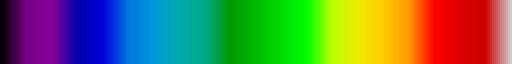

In [29]:
cmap=plt.get_cmap("nipy_spectral")
cmap

In [30]:
lpb = len(principal_bundles)
color_theme0 = cmap(np.linspace(0.1, 0.9, lpb))
#pseudo-randomize the colors
idx = np.array([_ * (lpb+8011) for _ in range(lpb)]) % lpb
print(idx)
color_theme = color_theme0[idx]

[ 0 21 42 63 84 11 32 53 74  1 22 43 64 85 12 33 54 75  2 23 44 65 86 13
 34 55 76  3 24 45 66 87 14 35 56 77  4 25 46 67 88 15 36 57 78  5 26 47
 68 89 16 37 58 79  6 27 48 69 90 17 38 59 80  7 28 49 70 91 18 39 60 81
  8 29 50 71 92 19 40 61 82  9 30 51 72 93 20 41 62 83 10 31 52 73]


In [31]:
b_vertex_to_position = {}
i = 0
for bundle in principal_bundles:
    for v in bundle[2]:
        vertex = tuple(v[:2])
        b_vertex_to_position[vertex] = i, bundle[0]
        i += 1

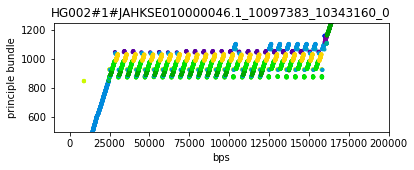

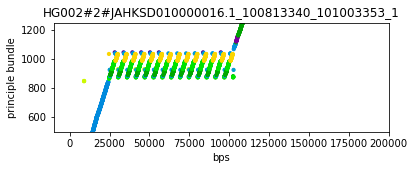

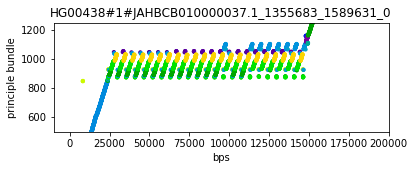

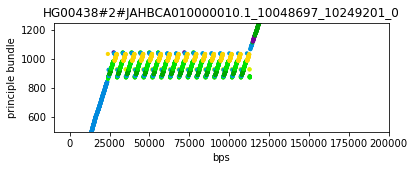

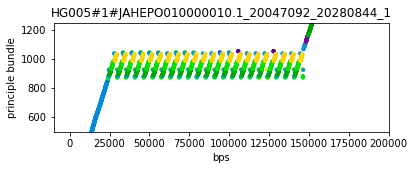

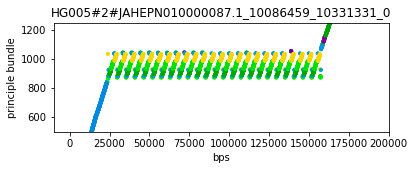

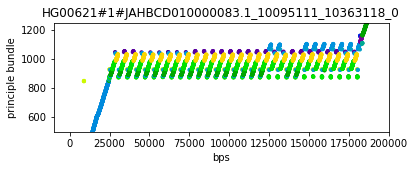

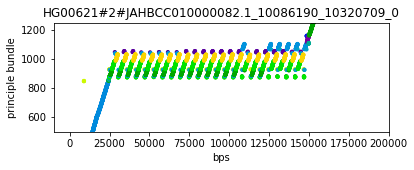

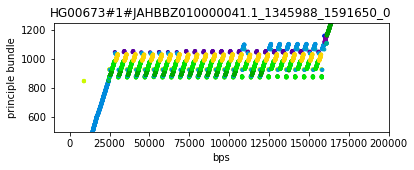

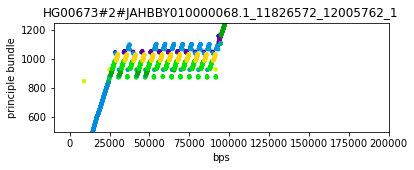

In [32]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

#fig = plt.figure(figsize=(24,96))
pidx = 1
for sid, data in sinfo[:10]:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    #track0_x = []
    #track0_c = []
    #matches = set([(_[0], _[1]) for _ in gene_matches[sid]])
    for s in smps:
        if s[1] is None:
            continue
        vertex = tuple(s[0][:2])
        x.append(s[0][2])
        y.append(b_vertex_to_position[vertex][0]) # same direction
        c.append(color_theme[s[1][0]])
            

    fig = plt.figure(figsize=(6,2))
    plt.scatter(x, y, marker=".", color=c, s=40)
    
    
    plt.xlim(-10000,200000)
    plt.ylim(500,1250)
    plt.title(ctg)
    plt.xlabel("bps")
    plt.ylabel("principle bundle")
    

In [33]:
from matplotlib.colors import to_hex as to_hex

In [34]:
new_sdb.generate_principal_mapg_gfa(0, 8, "LPA_principal_bundles.gfa")
v_to_name = {}
v_to_bundle_id = {}
with open("/results/LPA_principal_bundles.gfa") as f:
    for r in f:
        r = r.strip().split("\t")
        if r[0] != "S":
            continue
        n = r[1]
        v = r[4].split(":")[-1]
        v_to_name[v] = n

f = open("/results/LPA_principal_bundles_color.csv", "w")
print("Name,Color,Bundle_ID", file=f)
for bundle in principal_bundles:
    bundle_id = bundle[0]
    for v in bundle[2]:
        vertex = tuple(v[:2])
        color = to_hex(color_theme[bundle_id])
  
        print(v_to_name["{:016x}_{:016x}".format(*vertex)], color, bundle_id, file=f, sep=",")
f.close()

In [35]:
bundle_id_count = []
for sid, data in sinfo:
    smps = sid_smps[sid]
    for s in smps:
        if s[1] is not None:
            bundle_id_count.append(s[1][0])
    
bundle_id_count = Counter(bundle_id_count)

In [36]:
principal_bundles_length = dict([ (_[0], len(_[2])) for _  in principal_bundles ])

In [37]:
repeat_bundles = set()
for bid, count in bundle_id_count.items():
    if count/principal_bundles_length[bid] >= 92 * 4:
        repeat_bundles.add(bid)

In [38]:
repeat_bundles

{7, 8, 11, 16, 18, 19, 27, 28, 37, 38, 39}

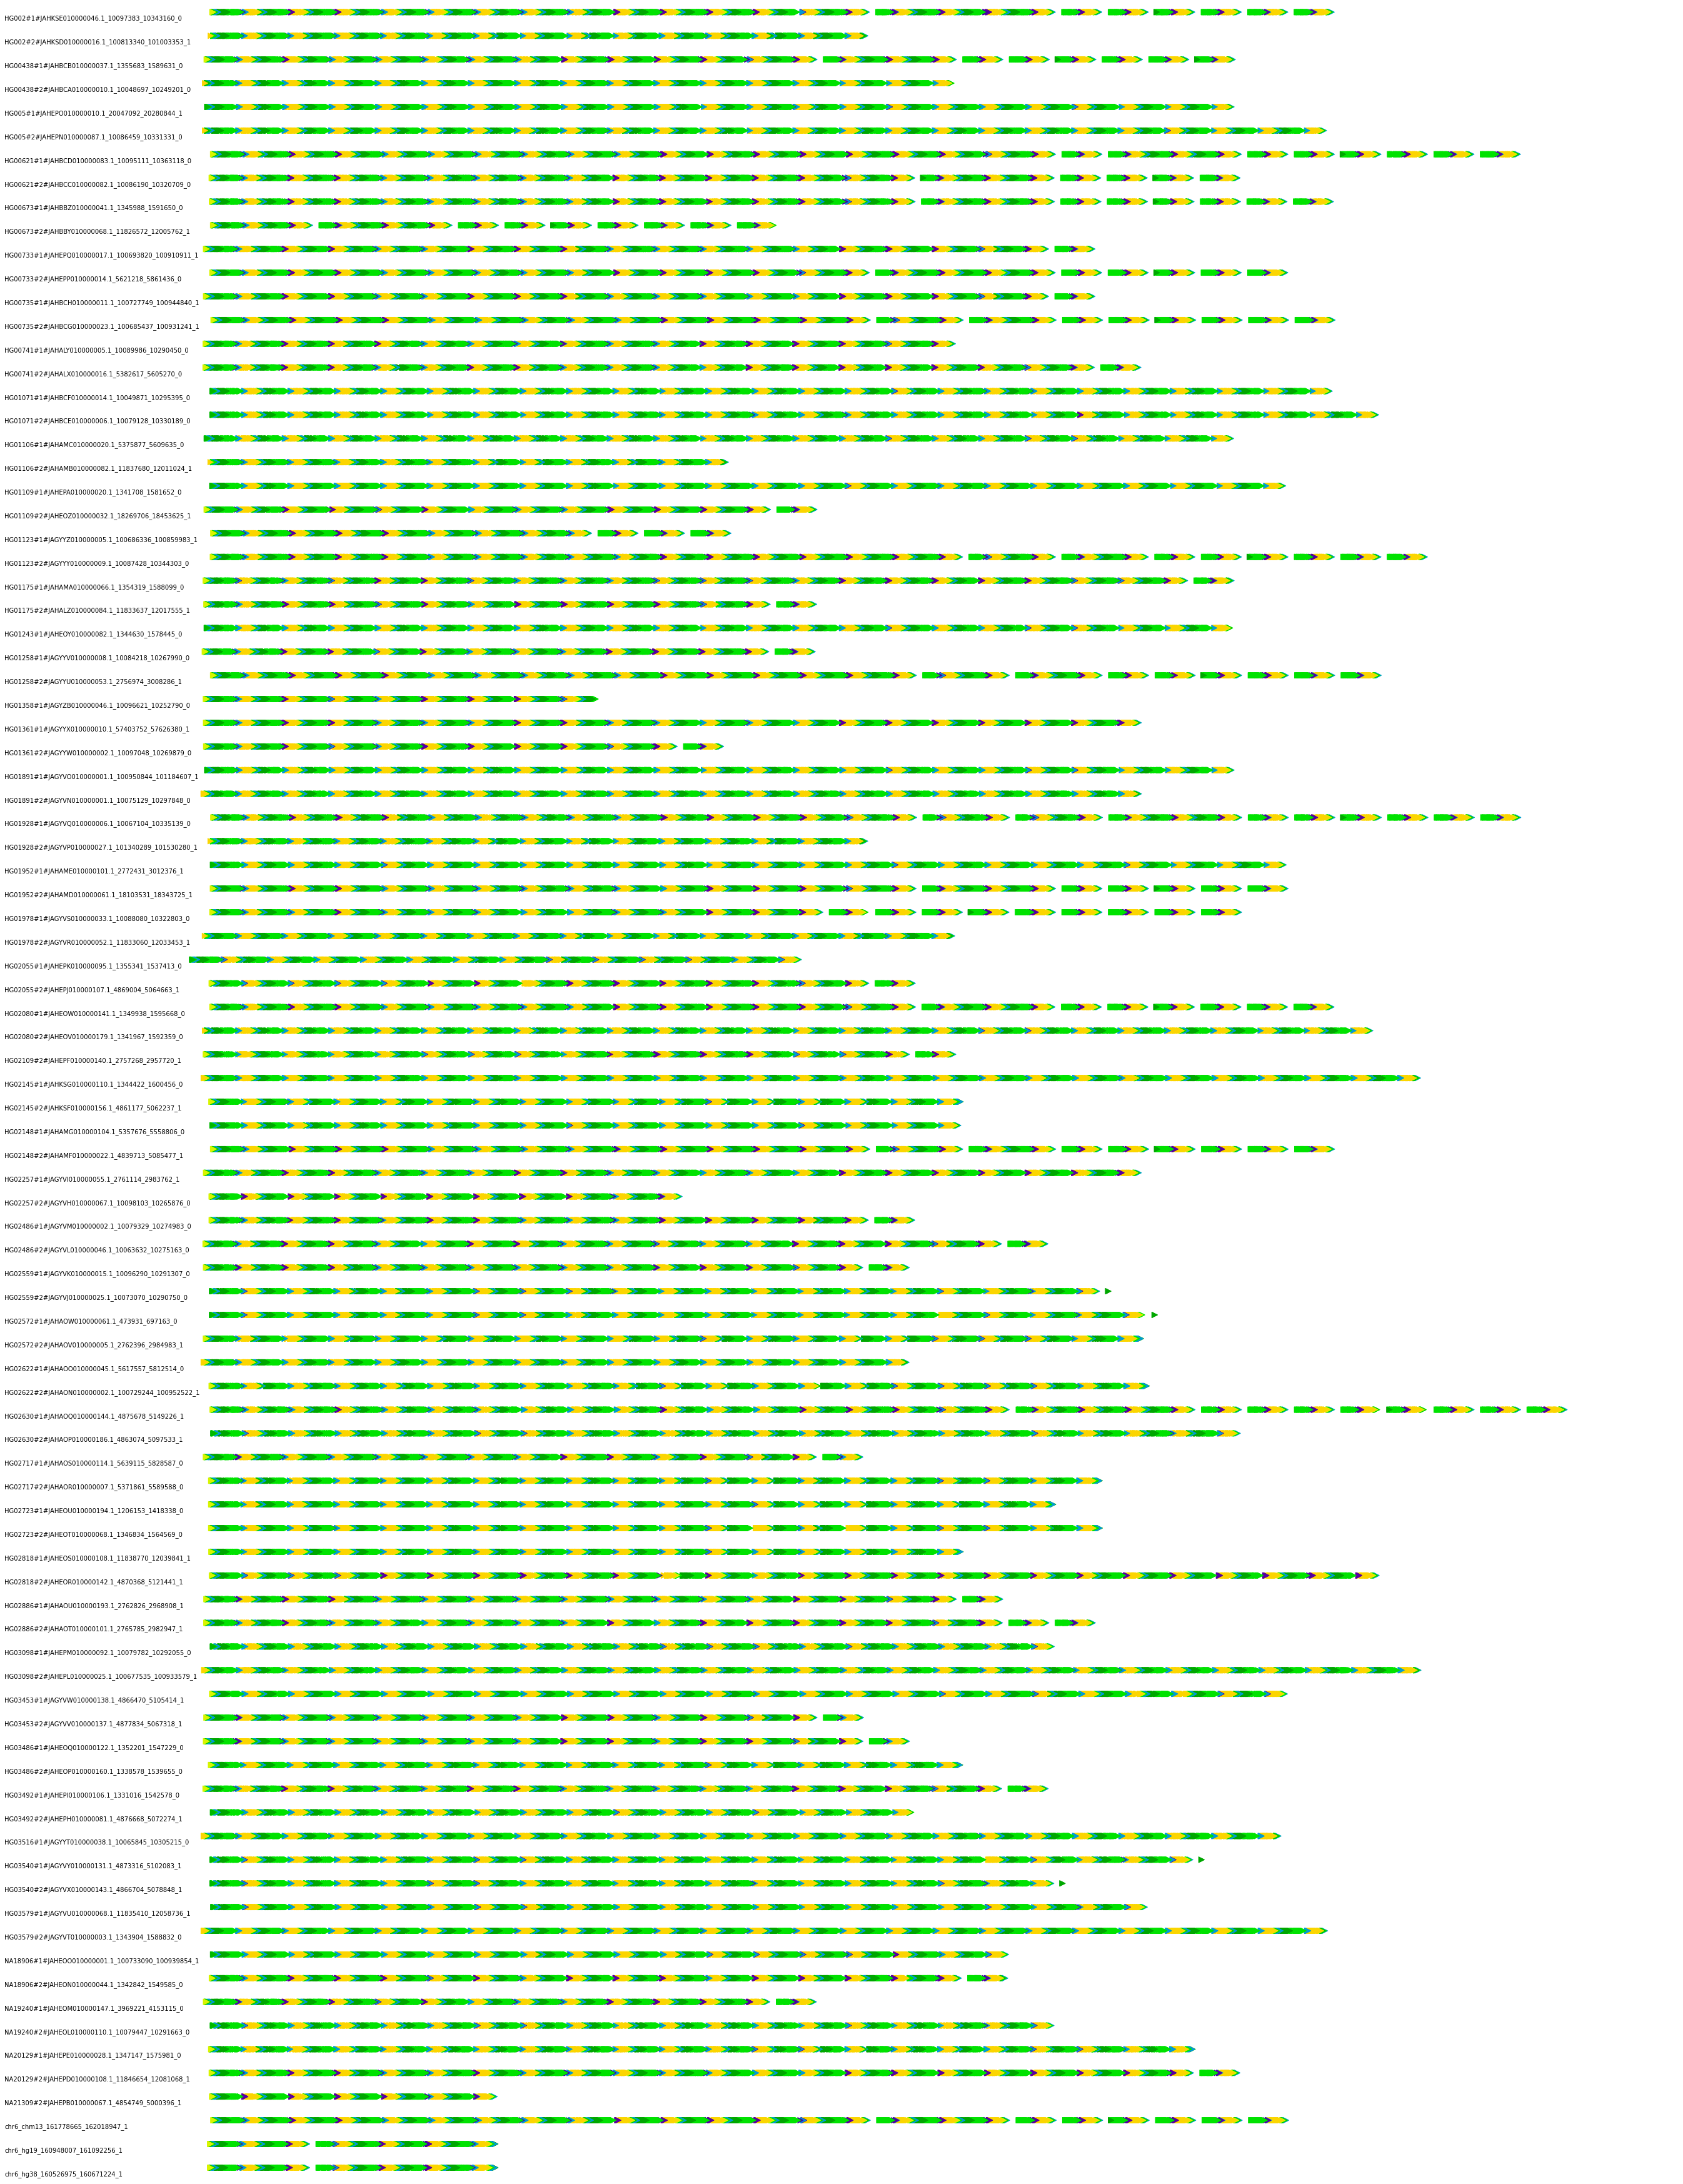

In [39]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

fig = plt.figure(figsize=(48,64))
pidx = 1
for sid, data in sinfo:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    track0_x = []
    track0_c = []
  
    for s in smps:
        if s[1] is None:
            continue
        if s[1][0] not in repeat_bundles:
            continue
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])
        # if tuple(s[0][2:4]) in matches:
        #     track0_x.append(s[0][2])
        #     track0_c.append(fcolors[s[1][0]])
            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.subplot(len(sid_smps), 1, pidx)

    pidx += 1
    plt.scatter(x, y, marker=">", color=c, s=80)
    plt.scatter(rx, ry, marker="<", color=rc, s=80)
    
    
    plt.axis("off")
    plt.ylim(-12,8)
    plt.xlim(0, 200000)
    plt.text(0, -8, ctg)

## Build repeat only sequnece database

Let's identify most common repeate element

In [40]:
bundle_id_count = []
for sid, data in sinfo:
    smps = sid_smps[sid]
    for s in smps:
        if s[1] is not None:
            bundle_id_count.append(s[1][0])
    
bundle_id_count = Counter(bundle_id_count)

In [41]:
principal_bundles_length = dict([ (_[0], len(_[2])) for _  in principal_bundles ])

In [42]:
repeat_bundles = set()
for bid, count in bundle_id_count.items():
    if count/principal_bundles_length[bid] > 97 * 3:
        print(bid, count/principal_bundles_length[bid])
        repeat_bundles.add(bid)

39 1513.3333333333333
38 1470.0
16 1755.2857142857142
37 1757.0
19 1524.8333333333333
11 1340.4166666666667
7 1549.4561403508771
27 373.5
28 946.5
8 1471.591836734694
18 566.6666666666666


In [43]:
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])
bundle_id_count = []
bundle_list = {}

# count most repeative bundle in a sequence
for seq_id, data in sinfo:

    smps = sid_smps[sid]

    bundle_list.setdefault(seq_id, [])
  
    for s in smps:
        if s[1] is None:
            continue
  
        smp = s[0]
        node = smp[0], smp[1]
        direction = smp[4]
        bundle_id = s[1][0]
        
        if bundle_id not in repeat_bundles:
            continue
  
        bundle_list[seq_id].append( bundle_id )
    


In [44]:
c = []
for seq_id, data in sinfo:
    c.extend(bundle_list[seq_id])
Counter(c).most_common(20)

[(7, 28336),
 (8, 23000),
 (11, 15088),
 (16, 4508),
 (19, 3312),
 (37, 1932),
 (18, 1932),
 (39, 1656),
 (38, 1564),
 (28, 828),
 (27, 552)]

###  fetch the repeat by breaking at the first shimmer pair of pincipal bundle 7 as it is more common element

In [45]:
repeat_start = {}
flag = 0
key_node = None
for seq_id, data in sinfo:
    ctg, src, _ = data
    #print(ctg, src)
    smps = pgrtk.get_shmmr_pairs_from_seq(seq_list[seq_id][1],  
                                          w = shmmrspec["w"], 
                                          k = shmmrspec["k"], 
                                          r = shmmrspec["r"],
                                          min_span = shmmrspec["min_span"])
    repeat_start.setdefault(seq_id, [])
    bundle_list.setdefault(seq_id, [])
    x = []
    
    for smp in smps:
        node = smp[0], smp[1]
        direction = smp[4]
        if node in b_vertex_to_position:
            if b_vertex_to_position[node][1] == 7:
                if flag == 0:
                    key_node = node
                    flag = 1
            else:
                flag = 0
                
            if key_node is not None and node == key_node:
                repeat_start[seq_id].append(smp[2])


In [46]:
f = open("/results/LPA_repeat_units.fa", "w")
f2 = open("/results/LPA_repeat_tail_units.fa", "w")

repeat_length = []
for seq_id, data in sinfo:
    ctg, src, _ = data

    rs = repeat_start[seq_id]
   
    for i in range(len(rs)-1):
        b, e = rs[i], rs[i+1]
        seq = pgrtk.u8_to_string(seq_list[seq_id][1][b:e])
        print(f">{ctg}:{b}_{e}", file=f)
        print(f"{seq}", file=f)
        repeat_length.append(len(seq))
        if len(seq) < 5000 or len(seq) > 6000:
            print(f">{ctg}:{b}_{e}", len(seq))
    
    b = rs[-1]
    e = b + 6500
    seq = pgrtk.u8_to_string(seq_list[seq_id][1][b:e])
    print(f">{ctg}:{b}_{e}", file=f2)
    print(f"{seq}", file=f2)
f.close()
f2.close()
        

In [47]:
!grep -c ">" /results/LPA_repeat_units.fa

1640


In [48]:
!grep -c ">" /results/LPA_repeat_tail_units.fa

92


5547.007317073171 14.227762113316457


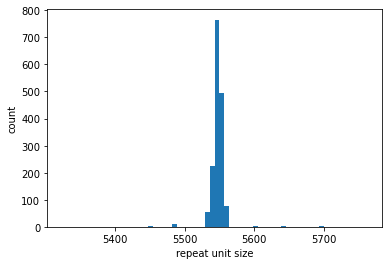

In [49]:
plt.hist(repeat_length, bins=64);
plt.xlabel("repeat unit size")
plt.ylabel("count")
print(np.mean(repeat_length), np.std(repeat_length))

In [50]:
!grep -A 1 chr6_hg38_160526975_160671224_1:26434_31981 LPA_repeat_units.fa  > /results/GRCh38_LPA_repeat_unit_ref.fa

In [51]:
%%bash
cd /results/
minimap2 -x asm5 -a -z200000,10000 GRCh38_LPA_repeat_unit_ref.fa LPA_repeat_units.fa | samtools view -bS  - | samtools sort -  > LPA_repeat_units.bam
minimap2 -x asm5 -a -z200000,10000 GRCh38_LPA_repeat_unit_ref.fa LPA_repeat_tail_units.fa | samtools view -bS  - | samtools sort - > LPA_repeat_tail_units.bam
samtools index LPA_repeat_units.bam
samtools index LPA_repeat_tail_units.bam
minimap2 -x sr -a GRCh38_LPA_repeat_unit_ref.fa /code/LPA_mRNA.fa  | samtools view -bS - | samtools sort - > LPA_mRNA.bam
samtools index LPA_mRNA.bam

[M::mm_idx_gen::0.002*2.07] collected minimizers
[M::mm_idx_gen::0.004*2.34] sorted minimizers
[M::main::0.004*2.32] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.004*2.26] mid_occ = 100
[M::mm_idx_stat] kmer size: 19; skip: 19; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.004*2.22] distinct minimizers: 556 (99.82% are singletons); average occurrences: 1.011; average spacing: 9.870
[M::worker_pipeline::1.014*2.48] mapped 1640 sequences
[M::main] Version: 2.15-r905
[M::main] CMD: minimap2 -x asm5 -a -z200000,10000 GRCh38_LPA_repeat_unit_ref.fa LPA_repeat_units.fa
[M::main] Real time: 1.015 sec; CPU: 2.521 sec; Peak RSS: 0.012 GB
[M::mm_idx_gen::0.002*2.64] collected minimizers
[M::mm_idx_gen::0.003*2.74] sorted minimizers
[M::main::0.003*2.72] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.003*2.64] mid_occ = 100
[M::mm_idx_stat] kmer size: 19; skip: 19; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.004*2.57] distinct minimizers: 556 (99.82% are singl

## Create a new sequence database object and generate the principal bundles

In [52]:
shmmrspec = {"w": 56, "k":56, "r":1, "min_span":0 }
repeat_db = pgrtk.SeqIndexDB() 
repeat_db.load_from_fastx("/results/LPA_repeat_units.fa", 
                           w = shmmrspec["w"], 
                           k = shmmrspec["k"], 
                           r = shmmrspec["r"], 
                           min_span = shmmrspec["min_span"])


In [53]:
repeat_principal_bundles, repeat_sid_to_smps = repeat_db.get_principal_bundle_decomposition(0, 24);
repeat_sid_to_smps = dict(repeat_sid_to_smps)

get the vertex to bundle id map

In [54]:
vertex_to_bundle_id = {}
x = 0
bundle_id = 0
for bundle_id, order, bundle in repeat_principal_bundles:
    for v in bundle:
        vertex_to_bundle_id[tuple(v[:2])] = bundle_id, v[2]

### Generate A GFA file of the repeat graph with pricinple bundle color annotation

In [55]:
from matplotlib.colors import to_hex as to_hex

In [56]:
repeat_db.generate_mapg_gfa(0, "/results/LPA_repeats.gfa")

v_to_name = {}
with open("/results/LPA_repeats.gfa") as f:
    for r in f:
        r = r.strip().split("\t")
        if r[0] != "S":
            continue
        n = r[1]
        v = r[4].split(":")[-1]
        v_to_name[v] = n

f = open("/results/LPA_repeats_color.csv", "w")

lpb = len(principal_bundles)
color_theme0 = cmap(np.linspace(0.1, 0.9, lpb))
#pseudo-randomize the colors
idx = np.array([_ * (lpb+8011) for _ in range(lpb)]) % lpb
print(idx)
color_theme = color_theme0[idx]

print("Name,Color", file=f)
for bundle_id, _, bundle in repeat_principal_bundles:
    for v in bundle:
        vertex = tuple(v[:2])
        bundle_id = vertex_to_bundle_id[tuple(v[:2])][0]
        color = to_hex(color_theme[bundle_id])
        #color = color.to_hex()
        print(v_to_name["{:016x}_{:016x}".format(*vertex)], color, file=f, sep=",")
f.close()

[ 0 21 42 63 84 11 32 53 74  1 22 43 64 85 12 33 54 75  2 23 44 65 86 13
 34 55 76  3 24 45 66 87 14 35 56 77  4 25 46 67 88 15 36 57 78  5 26 47
 68 89 16 37 58 79  6 27 48 69 90 17 38 59 80  7 28 49 70 91 18 39 60 81
  8 29 50 71 92 19 40 61 82  9 30 51 72 93 20 41 62 83 10 31 52 73]


assign position of each vertex in the principal bundle

In [57]:
b_vertex_to_position = {}
i = 0
for bundle in repeat_principal_bundles:
    if len(bundle[2]) == 1: # some small segment used in both directions
        continue
    for v in bundle[2]:
        vertex = tuple(v[:2])
        if vertex in b_vertex_to_position: # some small segment used in both directions
            continue
        b_vertex_to_position[vertex] = i, bundle[0]
        i += 1

construct vector of each repet unit by the projection to the bundles

In [58]:

seq_info = repeat_db.seq_info.copy()

sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

s_vectors = np.zeros( (len(repeat_sid_to_smps), len(b_vertex_to_position)))

ctg_labels = [""]*len(repeat_sid_to_smps)


for sid, smps in repeat_sid_to_smps.items(): 
    ctg, src, _ = seq_info[sid]
    for smp, bundle_id in smps:
        if bundle_id is None:
            continue
        node = smp[0], smp[1]
        direction = smp[4]

        if node in b_vertex_to_position:
            s_vectors[sid, b_vertex_to_position[node][0]] += 1
    ctg_labels[sid]=ctg


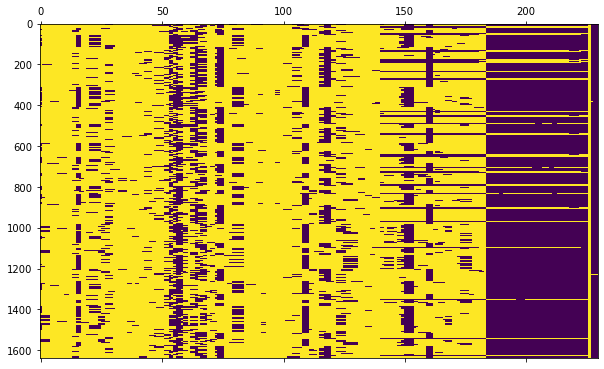

In [59]:
plt.figure(figsize=(10,6))
plt.matshow(s_vectors, fignum=1,  aspect='auto')

create a PCA plot of the repeat-bundle projection vectors 

In [60]:
from sklearn.decomposition import PCA

In [61]:
sample2eth = {}
with open("/code/HPRC_y1_ethnic.csv") as f:
    for r in f:
        r = r.strip().split()
        sample2eth[r[0]] = r[2]

In [62]:
eths = []
for c in ctg_labels:
    #print(c, sample2eth.get(c.split("#")[0], "NA"))
    eths.append(sample2eth.get(c.split("#")[0], "NA"))

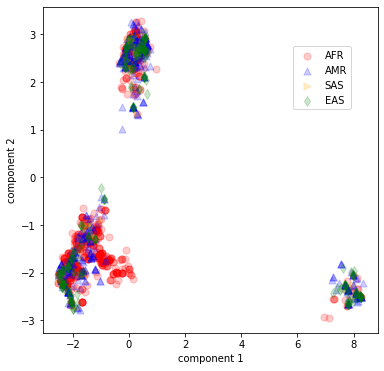

In [63]:
pca = PCA(n_components=2)
comp = pca.fit_transform(s_vectors)

[x, y] = zip( *[ (_[0], _[1]) for _ in comp ] )
c_map = {"AFR":"red", "AMR": "blue", "SAS": "orange", "EAS":"green" }
m_map = {"AFR":"o", "AMR": "^", "SAS": ">", "EAS":"d" }
colors = []

ax=plt.figure(figsize=(6,6))
for eth, color in c_map.items():
    xx = []
    yy = []
    for i in range(len(x)):
        #plt.text(x[i], y[i], eths[i])
        if eths[i] != eth:
            continue
        xx.append(x[i])
        yy.append(y[i])
    plt.scatter(xx, yy, alpha=0.2, marker=m_map[eth], c=color, s=50, label=eth)

ax.legend(bbox_to_anchor=(0.850, 0.8), loc="upper right")

plt.xlabel("component 1")
plt.ylabel("component 2")
pca_x = x[:]
pca_y = y[:]

plot the vectors of the three groups of repeat elements

In [64]:

s_vectors = np.zeros( (len(repeat_sid_to_smps), len(b_vertex_to_position)))

ctg_labels = [""]*len(repeat_sid_to_smps)
group1_sid = []
for sid, smps in repeat_sid_to_smps.items():
    if pca_y[sid] < 0:
        continue
    ctg, src, _ = seq_info[sid]
    group1_sid.append(sid)
    for smp, bundle_id in smps:
        if bundle_id is None:
            continue
        node = smp[0], smp[1]
        direction = smp[4]

        if node in b_vertex_to_position:
            s_vectors[sid, b_vertex_to_position[node][0]] += 1
            
    ctg_labels[sid]=ctg



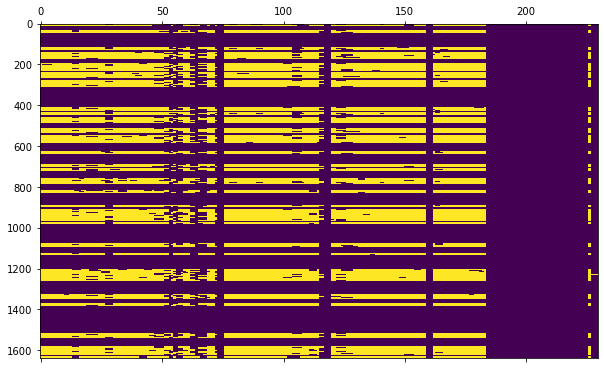

In [65]:
plt.figure(figsize=(10,6))
plt.matshow(s_vectors, fignum=1, aspect='auto')

In [66]:

s_vectors = np.zeros( (len(repeat_sid_to_smps), len(b_vertex_to_position)))

ctg_labels = [""]*len(repeat_sid_to_smps)
group2_sid = []
for sid, smps in repeat_sid_to_smps.items():
    if pca_y[sid] > 0:
        continue
    if pca_x[sid] > 2:
        continue
    ctg, src, _ = seq_info[sid]
    group2_sid.append(sid)
    for smp, bundle_id in smps:
        if bundle_id is None:
            continue
        node = smp[0], smp[1]
        direction = smp[4]

        if node in b_vertex_to_position:
            s_vectors[sid, b_vertex_to_position[node][0]] += 1
            
    ctg_labels[sid]=ctg




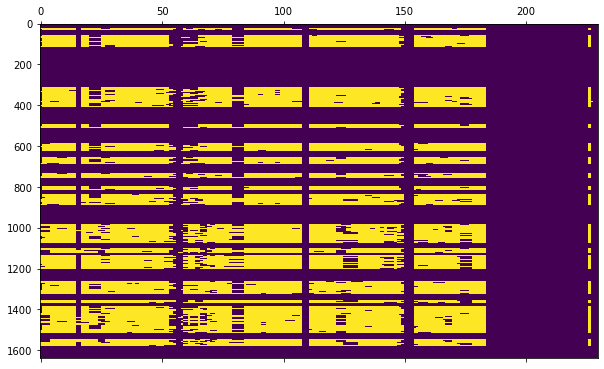

In [67]:
plt.figure(figsize=(10,6))
plt.matshow(s_vectors, fignum=1,  aspect='auto')



In [68]:

s_vectors = np.zeros( (len(repeat_sid_to_smps), len(b_vertex_to_position)))

ctg_labels = [""]*len(repeat_sid_to_smps)
group3_sid = []
for sid, smps in repeat_sid_to_smps.items():
    if pca_y[sid] > 0:
        continue
    if pca_x[sid] < 2:
        continue
    ctg, src, _ = seq_info[sid]
    group3_sid.append(sid)
    for smp, bundle_id in smps:
        if bundle_id is None:
            continue
        node = smp[0], smp[1]
        direction = smp[4]

        if node in b_vertex_to_position:
            s_vectors[sid, b_vertex_to_position[node][0]] += 1
            
    ctg_labels[sid]=ctg





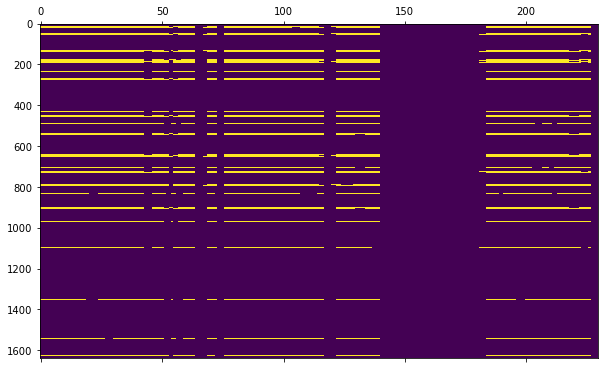

In [69]:
plt.figure(figsize=(10,6))
plt.matshow(s_vectors, fignum=1,  aspect='auto')



In [70]:
print(len(group1_sid), len(group2_sid), len(group3_sid))
print(len(group1_sid) + len(group2_sid) + len(group3_sid))

686 799 155
1640


In [71]:


group1_seqs = []
with open("LAP_repeat_type1.fa", "w") as f:
    for sid in group1_sid:
        ctg, src, _ = seq_info[sid]
        seq = repeat_db.get_seq_by_id(sid)
        group1_seqs.append(seq)
        print(">{}".format(ctg),file=f)
        print(pgrtk.u8_to_string(seq), file=f)
    
group2_seqs = []
with open("LAP_repeat_type2.fa", "w") as f:
    for sid in group2_sid:
        ctg, src, _ = seq_info[sid]
        seq = repeat_db.get_seq_by_id(sid)
        group2_seqs.append(seq)
        print(">{}".format(ctg),file=f)
        print(pgrtk.u8_to_string(seq), file=f)
    
group3_seqs = []
with open("LAP_repeat_type3.fa", "w") as f:
    for sid in group3_sid:
        ctg, src, _ = seq_info[sid]
        seq = repeat_db.get_seq_by_id(sid)
        group3_seqs.append(seq)
        print(">{}".format(ctg),file=f)
        print(pgrtk.u8_to_string(seq), file=f)



In [72]:
print(len(group1_seqs), len(group2_seqs), len(group3_seqs))
print(len(group1_seqs) + len(group2_seqs) + len(group3_seqs))

686 799 155
1640


In [73]:
!grep ">" GRCh38_LPA_repeat_unit_ref.fa 

>chr6_hg38_160526975_160671224_1:26434_31981


In [74]:
%%bash
cd /results/
minimap2 -x asm5 -a -z200000,10000 GRCh38_LPA_repeat_unit_ref.fa LAP_repeat_type1.fa | samtools view -bS  - | samtools sort -  > LPA_repeat_units_type1.bam
minimap2 -x asm5 -a -z200000,10000 GRCh38_LPA_repeat_unit_ref.fa LAP_repeat_type2.fa | samtools view -bS  - | samtools sort -  > LPA_repeat_units_type2.bam
minimap2 -x asm5 -a -z200000,10000 GRCh38_LPA_repeat_unit_ref.fa LAP_repeat_type3.fa | samtools view -bS  - | samtools sort -  > LPA_repeat_units_type3.bam

samtools index LPA_repeat_units_type1.bam
samtools index LPA_repeat_units_type2.bam
samtools index LPA_repeat_units_type3.bam

minimap2 -x sr -a GRCh38_LPA_repeat_unit_ref.fa /code/LPA_mRNA.fa  | samtools view -bS - | samtools sort - > LPA_mRNA.bam
samtools index LPA_mRNA.bam

[M::mm_idx_gen::0.002*2.06] collected minimizers
[M::mm_idx_gen::0.004*2.35] sorted minimizers
[M::main::0.004*2.33] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.004*2.28] mid_occ = 100
[M::mm_idx_stat] kmer size: 19; skip: 19; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.004*2.24] distinct minimizers: 556 (99.82% are singletons); average occurrences: 1.011; average spacing: 9.870
[M::worker_pipeline::0.454*2.55] mapped 686 sequences
[M::main] Version: 2.15-r905
[M::main] CMD: minimap2 -x asm5 -a -z200000,10000 GRCh38_LPA_repeat_unit_ref.fa LAP_repeat_type1.fa
[M::main] Real time: 0.456 sec; CPU: 1.159 sec; Peak RSS: 0.007 GB
[M::mm_idx_gen::0.002*2.20] collected minimizers
[M::mm_idx_gen::0.003*2.46] sorted minimizers
[M::main::0.003*2.45] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.003*2.40] mid_occ = 100
[M::mm_idx_stat] kmer size: 19; skip: 19; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.003*2.37] distinct minimizers: 556 (99.82% are single

In [75]:
g1_cns = pgrtk.guided_shmmr_dbg_consensus(group1_seqs, 17, 35, 1, 0)
g2_cns = pgrtk.guided_shmmr_dbg_consensus(group2_seqs, 17, 35, 1, 0)
g3_cns = pgrtk.guided_shmmr_dbg_consensus(group3_seqs, 17, 35, 1, 0)

In [76]:
len(g1_cns[0]), len(g2_cns[0]), len(g3_cns[0])

(5518, 5516, 5536)

In [77]:
g1_cns=pgrtk.u8_to_string(g1_cns[0])
g2_cns=pgrtk.u8_to_string(g2_cns[0])
g3_cns=pgrtk.u8_to_string(g3_cns[0])
f = open("LPA_repeat_cns1.fa","w")
print(">LPA_repeat_cns1", file=f)
print(g1_cns, file=f)
f.close()

f = open("LPA_repeat_cns2.fa","w")
print(">LPA_repeat_cns2", file=f)
print(g2_cns, file=f)
f.close()

f = open("LPA_repeat_cns3.fa","w")
print(">LPA_repeat_cns3", file=f)
print(g3_cns, file=f)
f.close()

In [78]:
!blasr LPA_repeat_cns2.fa LPA_repeat_cns1.fa -m 0

[INFO] 2022-08-13T16:36:06 [blasr] started.
    nMatch: 5503
 nMisMatch: 12
      nIns: 1
      nDel: 3
      %sim: 99.7101
     Score: -27423
         Query: LPA_repeat_cns2/0_5516
        Target: LPA_repeat_cns1
         Model: a hybrid of global/local non-affine alignment
     Raw score: -27423
        Map QV: 254
  Query strand: 0
 Target strand: 0
   QueryRange: 0 -> 5516 of 5516
  TargetRange: 0 -> 5518 of 5518
   0  TGTCTCAAGCTGAGTTCTCCGAACTCAACTTGTGACAGATGCAGATGGCG
      ||||||||||||||||||||||||||||||||||||||||||||||||||
   0  TGTCTCAAGCTGAGTTCTCCGAACTCAACTTGTGACAGATGCAGATGGCG

  50  TAGCAAAATGTCTCAGGATGATTGCCTTGGAGCTAAGGGTCTGAGAGAAG
      ||||||||||||||||||||||||||||||||||||||||||||||||||
  50  TAGCAAAATGTCTCAGGATGATTGCCTTGGAGCTAAGGGTCTGAGAGAAG

 100  GGAAATGTTAAGCTCCCTCTCCTTCCTCCTAGTTCTATTGAGCAGAAGGG
      ||||||||||||||||||||||||||||||||||||||||||||||||||
 100  GGAAATGTTAAGCTCCCTCTCCTTCCTCCTAGTTCTATTGAGCAGAAGGG

 150  AAATCTGGAGGTGAGGAGATCACATTATGAAGAAAGTCAGAATGACAAAG
      

In [79]:
!blasr LPA_repeat_cns3.fa LPA_repeat_cns1.fa -m 0

[INFO] 2022-08-13T16:36:07 [blasr] started.
    nMatch: 5406
 nMisMatch: 104
      nIns: 26
      nDel: 7
      %sim: 97.5284
     Score: -26241
         Query: LPA_repeat_cns3/0_5536
        Target: LPA_repeat_cns1
         Model: a hybrid of global/local non-affine alignment
     Raw score: -26241
        Map QV: 254
  Query strand: 0
 Target strand: 0
   QueryRange: 0 -> 5536 of 5536
  TargetRange: 0 -> 5517 of 5518
   0  TGTCTCAAGCTGAGTTCTCCGAACTCAACTTGTGACAGATGCAGATGGCG
      ||||||||||||||||||||||||||||||||||||||||||||||||||
   0  TGTCTCAAGCTGAGTTCTCCGAACTCAACTTGTGACAGATGCAGATGGCG

  50  TAGCAAAATGTCTCAGGATGATTGCCTTGGAGCTAAGGGTCTGAGAGAAG
      ||||||||||||||||||||||||||||||||||||||||||||||||||
  50  TAGCAAAATGTCTCAGGATGATTGCCTTGGAGCTAAGGGTCTGAGAGAAG

 100  GGAAATGTTAAGCTCCCTCTCCTTCCTCCTAGTTCTATTGAGCAGAAGGG
      ||||||||||||||||||||||||||||||||||||||||||||||||||
 100  GGAAATGTTAAGCTCCCTCTCCTTCCTCCTAGTTCTATTGAGCAGAAGGG

 150  AAATCTGGAGGTGAGGAGATCACATTATGAAGAAAGTCAGAATGACAAAG
    

In [80]:
!blasr LPA_repeat_cns3.fa LPA_repeat_cns2.fa -m 0

[INFO] 2022-08-13T16:36:09 [blasr] started.
    nMatch: 5399
 nMisMatch: 108
      nIns: 29
      nDel: 8
      %sim: 97.3846
     Score: -26162
         Query: LPA_repeat_cns3/0_5536
        Target: LPA_repeat_cns2
         Model: a hybrid of global/local non-affine alignment
     Raw score: -26162
        Map QV: 254
  Query strand: 0
 Target strand: 0
   QueryRange: 0 -> 5536 of 5536
  TargetRange: 0 -> 5515 of 5516
   0  TGTCTCAAGCTGAGTTCTCCGAACTCAACTTGTGACAGATGCAGATGGCG
      ||||||||||||||||||||||||||||||||||||||||||||||||||
   0  TGTCTCAAGCTGAGTTCTCCGAACTCAACTTGTGACAGATGCAGATGGCG

  50  TAGCAAAATGTCTCAGGATGATTGCCTTGGAGCTAAGGGTCTGAGAGAAG
      ||||||||||||||||||||||||||||||||||||||||||||||||||
  50  TAGCAAAATGTCTCAGGATGATTGCCTTGGAGCTAAGGGTCTGAGAGAAG

 100  GGAAATGTTAAGCTCCCTCTCCTTCCTCCTAGTTCTATTGAGCAGAAGGG
      ||||||||||||||||||||||||||||||||||||||||||||||||||
 100  GGAAATGTTAAGCTCCCTCTCCTTCCTCCTAGTTCTATTGAGCAGAAGGG

 150  AAATCTGGAGGTGAGGAGATCACATTATGAAGAAAGTCAGAATGACAAAG
    

In [81]:
sid_to_group = {}


for sid in group1_sid:
    sid_to_group[sid] = 1
for sid in group2_sid:
    sid_to_group[sid] = 2
for sid in group3_sid:
    sid_to_group[sid] = 3
    

In [82]:
sample_to_repeat_type = {}
sample2eth["chm13"] = ""
sample2eth["hg38"] = ""
for sid, smps in repeat_sid_to_smps.items():
    ctg, src, _ = seq_info[sid]
    ctg_id, rng = ctg.split(":")
    rng = list(int(_) for _ in rng.split("_"))
    rng.append(sid_to_group[sid])
    sample = ctg_id.split("#")[0]
    if sample == "chr6_hg19_160948007_161092256_1":
        continue
    if sample == "chr6_chm13_161778665_162018947_1":
        label = "chm13"
    elif sample == "chr6_hg38_160526975_160671224_1":
        label = "hg38"
    else:
        eth = sample2eth[sample]
        label = eth+":"+ctg_id
    
    sample_to_repeat_type.setdefault(label,[])
    sample_to_repeat_type[label].append(rng)

In [83]:
samples = list(sample_to_repeat_type.keys())
samples.sort()

Text(0.5, 0, 'bps')

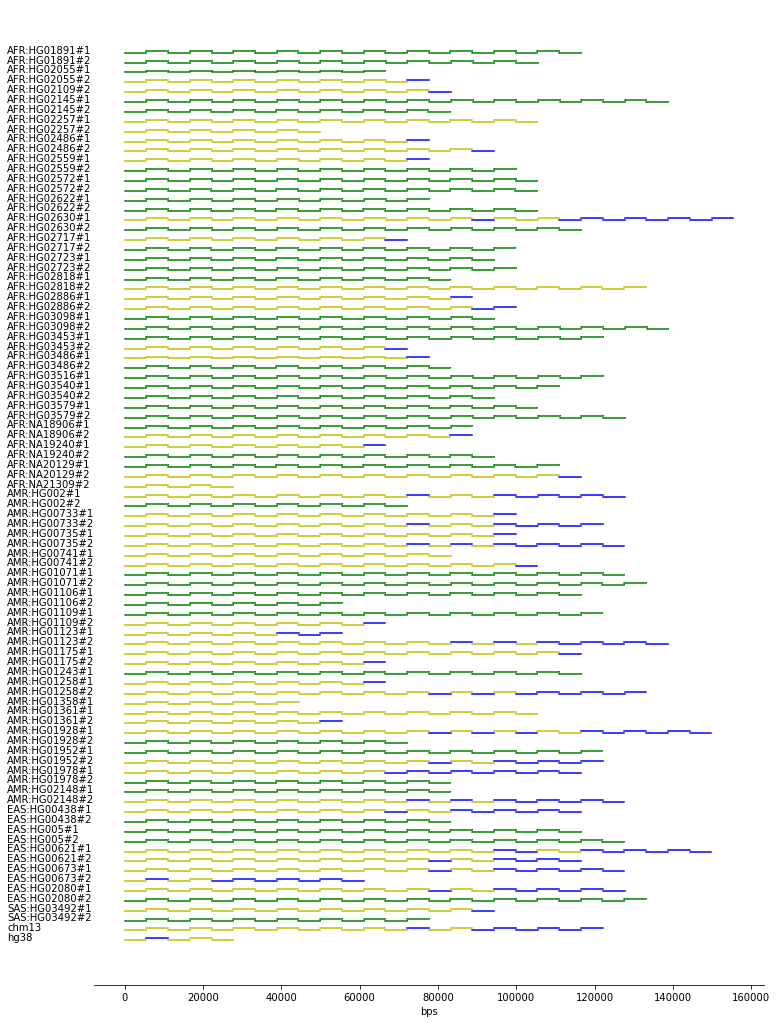

In [84]:
y = 0
fig=plt.figure(figsize=(12,18))
ax = plt.subplot(1,1,1)
col_map = {1: "y", 2: "g," , 3:"b"}
for sample in samples:
    sample_to_repeat_type[sample].sort()
    #print(ctg, ctg_to_repeat_type[ctg])
    offset = sample_to_repeat_type[sample][0][0]
    d = 0
    for s,e,t in sample_to_repeat_type[sample]:
        plt.plot([s-offset, e-offset], [y+d*0.2, y+d*0.2], "-"+col_map[t])
        #print(s,e,e-s,d)
        if e-s > 10000:
            print(s,e,e-s,d)
        d = 1-d
    label = sample.split("#")[:2]
    label = "#".join(label)
    plt.text(-30000, y, label)
    y-=1
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_ticks([])
plt.xlabel("bps")